In [1]:
import Pkg
codepath = joinpath("../") 
Pkg.activate("mergeSplit"; shared=true)

using Revise
using RandomNumbers
using Random
using MultiScaleMapSampler
using Test
using JSON 
using CSV 
using StatProfilerHTML
using Plots 
using StatsPlots

Pkg.develop(path=codepath)


  Activating project at `~/.julia/environments/mergeSplit`


   Resolving package versions...


  No Changes to `~/.julia/environments/mergeSplit/Project.toml`
  No Changes to `~/.julia/environments/mergeSplit/Manifest.toml`


In [2]:
CT_json = joinpath("test_graphs", "CT_pct20.json")
CT_node_data = Set(["COUNTY", "NAME", "POP20", "border_length", "area", "G20PREDEM", "G20PREREP"])
CT_base_graph = BaseGraph(CT_json, "POP20", inc_node_data=CT_node_data,
    area_col="area",node_border_col="border_length", edge_perimeter_col="length")

for k in CT_base_graph.node_attributes 
    k["county_and_pct"] = string(k["COUNTY"], ",",k["NAME"])
end 

Gct = MultiLevelGraph(CT_base_graph, ["county_and_pct"]);
CT_oriented_nbrs = JSON.parsefile("test_graphs/CT_pct20_oriented_nbrs.json")
CT_oriented_nbrs = Dict{GlobalID, Vector{GlobalID}}([parse(Int, k) => v for (k,v) in CT_oriented_nbrs]);

## Hierarchy creation

For graphs with a large population spread, we generate the hierarchy loosely in three phases: first, getting all the nodes to approximately the same population (order of magnitude), second, getting the hierarchy to have a good number of nodes relative to the number of districts, and then finally coarsening at a constant rate until the desired number of nodes is reached at the highest level. 

In [5]:
num_dists = 5
TH = TemperingHierarchy(Gct, CT_oriented_nbrs, "test_graphs/CTTH_5/tempered_hierarchy_")
add_level!(TH, [])

Gs = TH.graphs_by_level

rng = PCG.PCGStateOneseq(UInt64, 15157)
target_pops = []

max_pct_pop = maximum([get_node_population(Gs[1], x) for x in finest_level_nodes(Gs[1])])

tpop = sum([get_node_population(Gs[1], x) for x in finest_level_nodes(Gs[1])])

incr_size = [50,50,50,50,50,50]
rng_stability = [1,2,3,4,5,5]
to_use = [5,5,5,5,5,100]
mult = [1, 1, 1, 1, 1, 1]
popmult = [0.5, 0.5, 0.6, 0.6, 0.7, 0.7]
# step 1: get the populations loosely to the same order of magnitude
for i=1:6
    target_pop = max_pct_pop * popmult[i] 
    push!(target_pops, target_pop)

    matching, EWF = iso_matching3(Gs[end], TH.onbrs_by_level[end], target_pop, 1, rng);
    matching_to_use = collect(filter(
        x -> ((get_node_population(Gs[end], x.id1) + get_node_population(Gs[end], x.id2) 
            < target_pop * mult[i]) && (EWF(x.id1, x.id2) > exp(-19)))
            , matching))
    @show length(matching_to_use) 
    sort!(matching_to_use, by= # some perturbation so that all the big ones don't get clumped up
        (x -> (rand(rng) + rng_stability[i]) * (get_node_population(Gs[end], x.id1) + get_node_population(Gs[end], x.id2))))

    # now, try to add the matching in increments of about incr_size 
    n_levels = Int(round(length(matching_to_use)/incr_size[i]))
    if n_levels >= 2 
        level_size = Int(round(length(matching_to_use)/n_levels)) + 1
        boundaries = collect(1:level_size:length(matching_to_use))
        push!(boundaries, length(matching_to_use))

        even_boundaries = [mod(x, 2) == 0 ? x : x-1 for x in boundaries]
        even_boundaries = even_boundaries[1:(to_use[i] > 
            length(even_boundaries) ? length(even_boundaries) : to_use[i])]

        if mod(length(finest_level_nodes(Gs[end])), 2) == 1
            even_boundaries[end] += 1
        end

        @show n_levels, level_size, even_boundaries
        
        for j=1:length(even_boundaries)-1 
            if length(TH.graphs_by_level) in [6]
                halfpt = Int(round(1/2 * (even_boundaries[j] + even_boundaries[j+1])))
                halfpt = mod(halfpt, 2) == 0 ? halfpt : halfpt-1 
                add_level!(TH, matching_to_use[(even_boundaries[j]+1):halfpt])
                add_level!(TH, matching_to_use[(halfpt+1):even_boundaries[j+1]])
            else
                add_level!(TH, matching_to_use[(even_boundaries[j]+1):even_boundaries[j+1]])
            end
            check_onbr_numbers_match(TH.onbrs_by_level[end])

            @show length(TH.graphs_by_level)
        end
    elseif n_levels == 0 
        continue 
    else # n_levels == 1
        if mod(length(matching_to_use), 2) != 0 
            matching_to_use = matching_to_use[2:end]
        end
        add_level!(TH, matching_to_use)
        @show length(TH.graphs_by_level)
        check_onbr_numbers_match(TH.onbrs_by_level[end])
    end

#    add_level!(TH, matching_to_use)
    println("Added levels above ", i)
end
@show length(finest_level_nodes(Gs[end]))

(node_name(Gnc, delnode), delnode) = (["root", "pctsingle_525"], 525)
(i, length(matching)) = 

(500, 183)


length(matching_to_use) = 300
(n_levels, level_size, even_boundaries) = 

(6, 51, [0, 52, 102, 154, 205])


length(TH.graphs_by_level) = 3
length(TH.graphs_by_level) = 

4


length(TH.graphs_by_level) = 5
length(TH.graphs_by_level) = 

6
Added levels above 1
length(matching_to_use) = 

133
(n_levels, level_size, even_boundaries) = (3, 45, [0, 46, 90, 132])
length(TH.graphs_by_level) = 

8


length(TH.graphs_by_level) = 9
length(TH.graphs_by_level) = 

10
Added levels above 2
length(matching_to_use) = 

50
length(TH.graphs_by_level) = 11
Added levels above 3


length(matching_to_use) = 1
length(matching_to_use) = 

30
length(TH.graphs_by_level) = 12
Added levels above 5


length(matching_to_use) = 2
length(finest_level_nodes(Gs[end])) = 278


278

In [6]:
println("At step 2")

# step 2: get the number of nodes to be = num_dists * 2^k for some k 
rem_levels = Int(trunc(log(2, length(finest_level_nodes(TH.graphs_by_level[end])) / num_dists)))
num_matchings_to_make = length(finest_level_nodes(TH.graphs_by_level[end])) - (2^rem_levels * num_dists)

prop_of_nodes_to_match = (num_matchings_to_make/length(finest_level_nodes(TH.graphs_by_level[end])))
@show prop_of_nodes_to_match

matching = iso_matching(Gs[end], TH.onbrs_by_level[end], 
    tpop / (2^rem_levels * num_dists)*prop_of_nodes_to_match, 1, rng);
matching = collect(matching)
sort!(matching, by=(x -> (rand(rng)+5) * (get_node_population(Gs[end], x.id1) + get_node_population(Gs[end], x.id2))))
matching = matching[1:num_matchings_to_make]
@show length(TH.graphs_by_level), num_matchings_to_make

n_levels = Int(round(length(matching)/40))
if n_levels >= 2 
    level_size = Int(round(length(matching)/n_levels)) + 1
    boundaries = collect(1:level_size:length(matching))
    push!(boundaries, length(matching))
    even_boundaries = [mod(x, 2) == 0 ? x : x-1 for x in boundaries]

    @show n_levels, level_size, even_boundaries
    
    for j=1:length(even_boundaries)-1 
        if length(TH.graphs_by_level) in [12, 14, 16]
            halfpt = Int(round(1/2 * (even_boundaries[j] + even_boundaries[j+1])))
            halfpt = mod(halfpt, 2) == 0 ? halfpt : halfpt-1 
            add_level!(TH, matching[(even_boundaries[j]+1):halfpt])
            add_level!(TH, matching[(halfpt+1):even_boundaries[j+1]])
        else
            add_level!(TH, matching[(even_boundaries[j]+1):even_boundaries[j+1]])
        end
        @show length(TH.graphs_by_level)
    end
    check_onbr_numbers_match(TH.onbrs_by_level[end])
end

At step 2
prop_of_nodes_to_match = 0.4244604316546763
(length(TH.graphs_by_level), num_matchings_to_make) = 

(12, 118)
(n_levels, level_size, even_boundaries) = (3, 40, [0, 40, 80, 118])
length(TH.graphs_by_level) = 

14
length(TH.graphs_by_level) = 16
length(TH.graphs_by_level) = 

18


In [7]:
println("At step 3")
lims = [50, 30, 30, 30]

totpop = sum([get_node_population(Gs[end], x) for x in finest_level_nodes(Gs[end])])

for i=1:(rem_levels-2) # want 4 = 2^2 nodes remaining in each 
    target_pop = totpop / (length(finest_level_nodes(Gs[end]))/2)
    push!(target_pops, target_pop)

    matching = iso_matching2(Gs[end], TH.onbrs_by_level[end], target_pop, 20, rng);
    matching_to_use = collect(matching)
    sort!(matching_to_use, by= 
    (x -> (get_node_population(Gs[end], x.id1) + get_node_population(Gs[end], x.id2))))

    @show length(matching_to_use) 

    n_levels = Int(round(length(matching_to_use)/lims[i]))
    if n_levels >= 2 
        level_size = Int(round(length(matching_to_use)/n_levels)) + 1
        boundaries = collect(1:level_size:length(matching_to_use))
        push!(boundaries, length(matching_to_use))
        even_boundaries = [mod(x, 2) == 0 ? x : x-1 for x in boundaries]
        @show n_levels, level_size, even_boundaries
        
        for j=1:length(even_boundaries)-1 
            add_level!(TH, matching_to_use[(even_boundaries[j]+1):even_boundaries[j+1]])
            @show length(TH.graphs_by_level)
        end
    else # n_levels == 1
        if mod(length(matching_to_use), 2) != 0 
            matching_to_use = matching_to_use[2:end]
        end
        add_level!(TH, matching_to_use)
        @show length(TH.graphs_by_level)

    end    
    println("Added level above ", i)
end
3

At step 3


(sections1, sections2) = (Vector{Any}[[14157], [14153, 11112, 13149, 10043, 10057, 570]], Vector{Any}[])
(c1, c2) = (13142, 16197)
onbrs = Any[Any[14157], Any[14153, 11112, 13149, 10043, 10057, 570, 12115, 15191, 17213]]
length(matching_to_use) = 

80
(n_levels, level_size, even_boundaries) = (2, 41, [0, 42, 80])
length(TH.graphs_by_level) = 19


length(TH.graphs_by_level) = 20
Added level above 1
length(matching_to_use) = 40
length(TH.graphs_by_level) = 21
Added level above 2
length(matching_to_use) = 20
length(TH.graphs_by_level) = 22
Added level above 3


3

## Sanity checks 

Here, we verify that the iso scores vary smoothly, that the population of the nodes gets tighter as you go up the hierarchy, and similar. 

In [6]:
filename_prefix = "test_graphs/CTTH_4/tempered_hierarchy_"
TH = TemperingHierarchy(Gct, filename_prefix, 22);

In [ ]:
ideal_pop = get_node_population(Gct, Gct.root.global_ID) / num_dists

pop_mins_maxs = [(ideal_pop*(1-pop_dev), ideal_pop*(1+pop_dev)) for pop_dev in [0.9]]
constraint = initialize_constraints() 
add_constraint!(constraint, PopulationConstraint(pop_mins_maxs[1][1], pop_mins_maxs[1][2]))
add_constraint!(constraint, ConstrainDiscontinuousTraversals())
        
for t=1:19
    partition = MultiLevelPartition(TH.graphs_by_level[t], constraint, 5; rng=rng, max_attempts=100)
    @show articulation_points(partition, collect(1:5))
end

In [105]:
Gs = TH.graphs_by_level
merged_pops = [] 
log_merged_pops = []
merged_compactness = []
delta_comp = []
for level=1:length(Gs)-1 
    push!(merged_pops, [])
    push!(merged_compactness, [])
    push!(log_merged_pops, [])
    push!(delta_comp, [])
    for n in finest_level_nodes(Gs[level])
        p = TH.parents_by_level[level][n]
        if length(TH.children_by_level[level+1][p]) == 2 
            s1, s2 = collect(TH.children_by_level[level+1][p])

            push!(merged_pops[end], get_node_population(Gs[level], n))
            push!(log_merged_pops[end], log10(get_node_population(Gs[level], n)))
            push!(merged_compactness[end], get_node_perimeter(Gs[level], n)^2 / get_node_area(Gs[level], n))
            push!(delta_comp[end], 
                0.5 * get_node_perimeter(Gs[level], s1)^2 / get_node_area(Gs[level], s1) + 
                0.5 * get_node_perimeter(Gs[level], s2)^2 / get_node_area(Gs[level], s2) - 
                get_node_perimeter(Gs[level+1], p)^2 / get_node_area(Gs[level+1], p))
        end
    end
    if length(merged_pops[end]) == 0 
        push!(merged_pops[end], 0)
    end
end
avg_merged_pops = [length(x) == 0 ? 0 : sum(x)/length(x) for x in merged_pops];


n = 6935
n = 2780
n = 1742
n = 7974
n = 3818
n = 128


21-element Vector{Float64}:
     0.0
  2541.8076923076924
  4085.625
  4703.423076923077
  5022.754716981132
  4385.145833333333
  5456.416666666667
  5999.104166666667
  6104.056818181818
  7352.65625
     ⋮
 11132.431818181818
 11969.7
 12469.795454545454
 13692.575
 14050.475
 20737.97619047619
 24525.71052631579
 45074.3
 90148.6

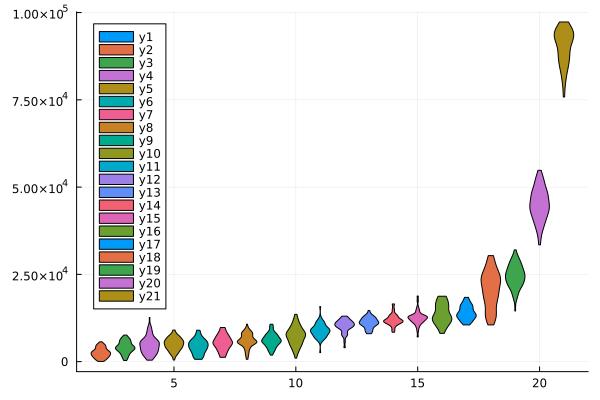

In [106]:
violin(merged_pops)

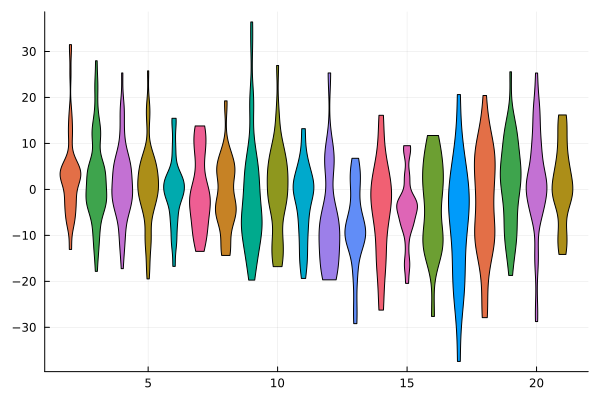

In [107]:
delta_comp[1] = [0] 
violin(delta_comp, legend=false)

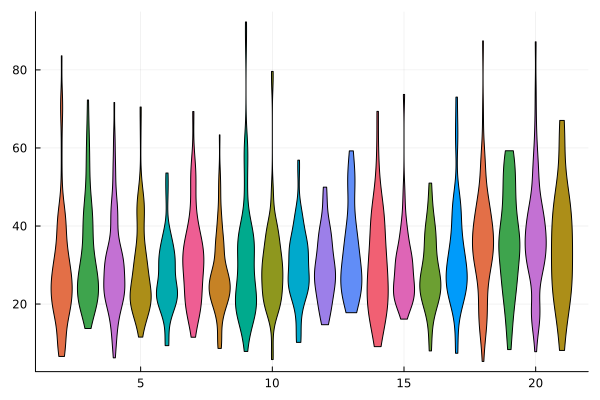

In [108]:
merged_compactness[1] = [0]
violin(merged_compactness, legend=false)

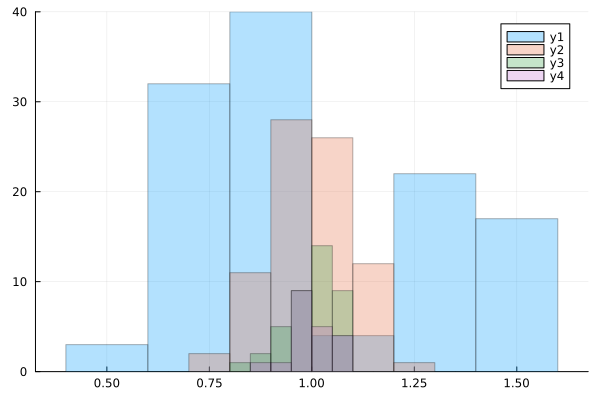

In [109]:
Gs = TH.graphs_by_level

popl = [] 
for i=1:length(Gs)
    push!(popl, [get_node_population(Gs[i], x) for x in finest_level_nodes(Gs[i])])
end

totpop = sum(popl[1])

j = 19
histogram(popl[j] ./ (sum(popl[j]) / length(popl[j])), alpha=0.3)
j = 20
histogram!(popl[j] ./ (sum(popl[j]) / length(popl[j])), alpha=0.3)
j = 21
histogram!(popl[j] ./ (sum(popl[j]) / length(popl[j])), alpha=0.3)
j = 22
histogram!(popl[j] ./ (sum(popl[j]) / length(popl[j])), alpha=0.3, bins=0.6:0.05:1.4)